# Классификация твитов с использованием GPT

In [ ]:
!pip install -q transformers datasets tokenizers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего.

In [ ]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)


In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
# Для перевода текста использован предобученный BPE-токенайзер.

tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0],
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [ ]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}

    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]

        tokenizer_output = tokenizer.encode_plus(
                    text,
                    max_length=128, # максимальная длина текста
                    padding="max_length", # надо ли добавлять паддинг в конце?
                    return_tensors="pt", # возвращает pytorch тензоры
                                                )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'],
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }

    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

In [ ]:
train_dataset = TweetDataset('train', emotion_dataset, tokenizer, 128)
valid_dataset = TweetDataset('validation', emotion_dataset, tokenizer, 128) # validation
test_dataset = TweetDataset('test', emotion_dataset, tokenizer, 128)

In [ ]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [ ]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=len(train_dataset.labels)
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Инициализация оптимизатора и функции потерь:

In [ ]:
lr = 1e-4

optimizer = torch.optim.Adam(model_0.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
            optimizer.zero_grad()
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(batch_size, 128).to(device)
            mask = batch['mask'].view(batch_size, 128).to(device)
            outputs = model_0(tokens, attention_mask = mask)
            loss = criterion(outputs[0].to(device), target)
            loss.backward()
            optimizer.step()
            if e == 6:
                optimizer = torch.optim.Adam(model_0.parameters(), lr = 1e-5)
            if e == 9:
                optimizer = torch.optim.Adam(model_0.parameters(), lr = 5e-6)
            train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            optimizer.zero_grad()
            size = batch['input_ids'].shape[0]
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(size, 128).to(device)
            mask = batch['mask'].view(size, 128).to(device)
            outputs = model_0(tokens, attention_mask = mask)
            output_tensor = outputs[0].to(device)
            output_tensor = torch.argmax(output_tensor, dim = 1)
            val_loss = criterion(outputs[0], target)
            valid_acc = accuracy_score(target.cpu(), output_tensor.cpu())
            optimizer.step()
            valid_loss += val_loss.item()

    print(f"Train Loss: {train_loss / len(train_loader)},"
           f"Valid Loss: {valid_loss / len(valid_loader)},"
           f"Valid Acc: {valid_acc}")

# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    i = 0
    test_acc = 0
    for batch in test_loader:
            i+=1
            optimizer.zero_grad()
            size = batch['input_ids'].shape[0]
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(size, 128).to(device)
            mask = batch['mask'].view(size, 128).to(device)
            outputs = model_0(tokens, attention_mask = mask)
            output_tensor = outputs[0].to(device)
            output_tensor = torch.argmax(output_tensor, dim = 1)
            test_acc += accuracy_score(target.cpu(), output_tensor.cpu())
print(f"Test Acc для непредтренированной модели: {test_acc/i}")

In [ ]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))

    return np.array(attn)

In [ ]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq[1:], rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq[1:], fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
text = emotion_dataset["train"]["text"][1] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

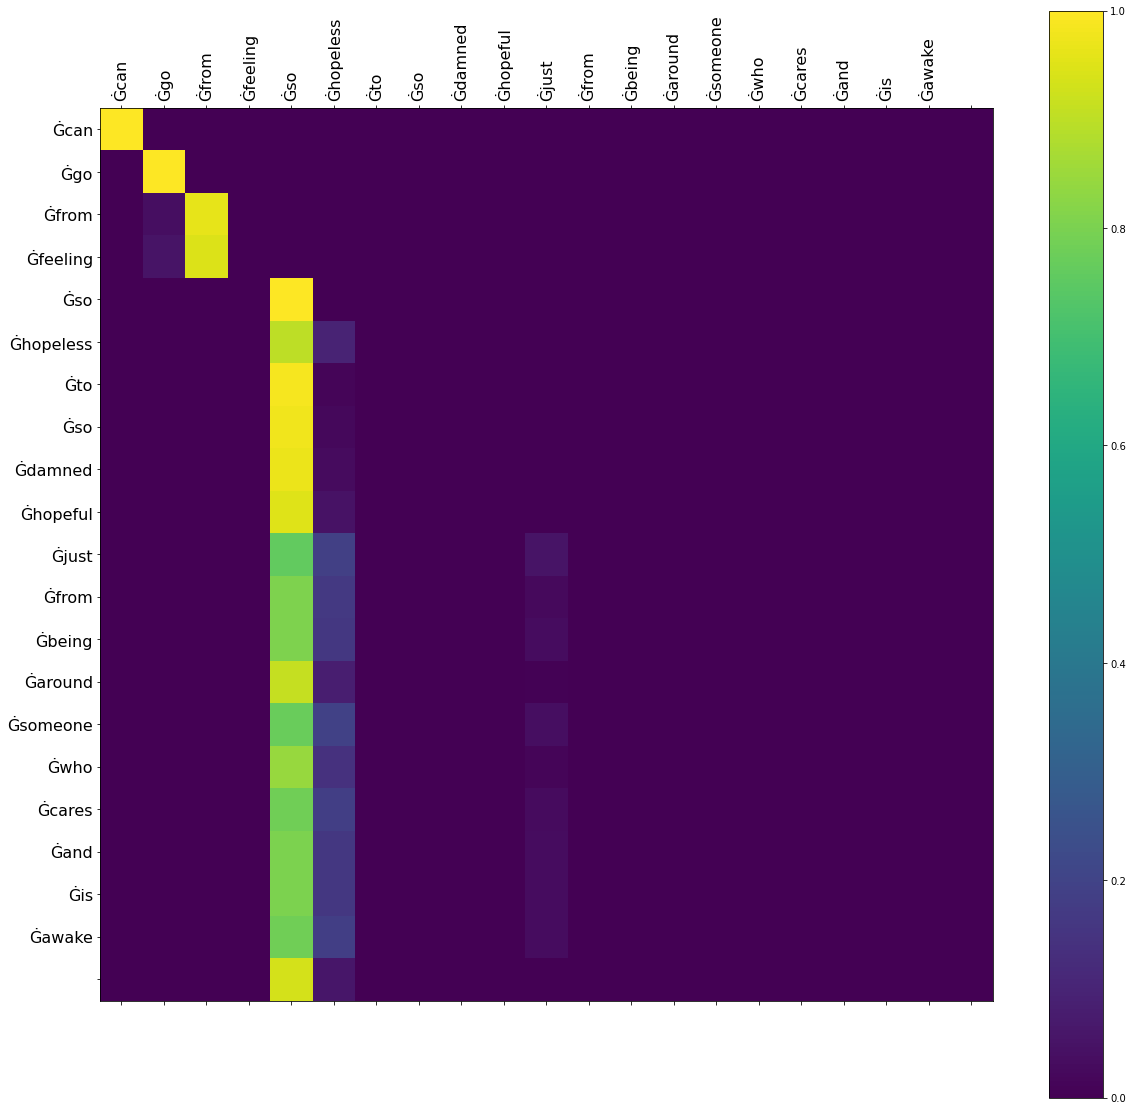

In [ ]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2",
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1e-4

optimizer = torch.optim.Adam(model_1.parameters())
criterion = nn.CrossEntropyLoss()


In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
            optimizer.zero_grad()
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(batch_size, 128).to(device)
            mask = batch['mask'].view(batch_size, 128).to(device)
            outputs = model_1(tokens, attention_mask = mask)
            loss = criterion(outputs[0].to(device), target)
            loss.backward()
            optimizer.step()
            if e == 6:
                optimizer = torch.optim.Adam(model_0.parameters(), lr = 1e-5)
            if e == 9:
                optimizer = torch.optim.Adam(model_0.parameters(), lr = 5e-6)
            train_loss += loss.item()
            train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            optimizer.zero_grad()
            size = batch['input_ids'].shape[0]
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(size, 128).to(device)
            mask = batch['mask'].view(size, 128).to(device)
            outputs = model_1(tokens, attention_mask = mask)
            output_tensor = outputs[0].to(device)
            output_tensor = torch.argmax(output_tensor, dim = 1)
            val_loss = criterion(outputs[0], target)
            valid_acc = accuracy_score(target.cpu(), output_tensor.cpu())
            optimizer.step()
            valid_loss += val_loss.item()

    print(f"Train Loss: {train_loss / len(train_loader)},"
           f"Valid Loss: {valid_loss / len(valid_loader)},"
           f"Valid Acc: {valid_acc}")

# Testing
with torch.no_grad():
    i = 0
    test_acc = 0
    for batch in test_loader:
            i+=1
            optimizer.zero_grad()
            size = batch['input_ids'].shape[0]
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(size, 128).to(device)
            mask = batch['mask'].view(size, 128).to(device)
            outputs = model_1(tokens, attention_mask = mask)
            output_tensor = outputs[0].to(device)
            output_tensor = torch.argmax(output_tensor, dim = 1)
            test_acc += accuracy_score(target.cpu(), output_tensor.cpu())
print(f"Test Acc для предтренированной модели: {test_acc/i}")

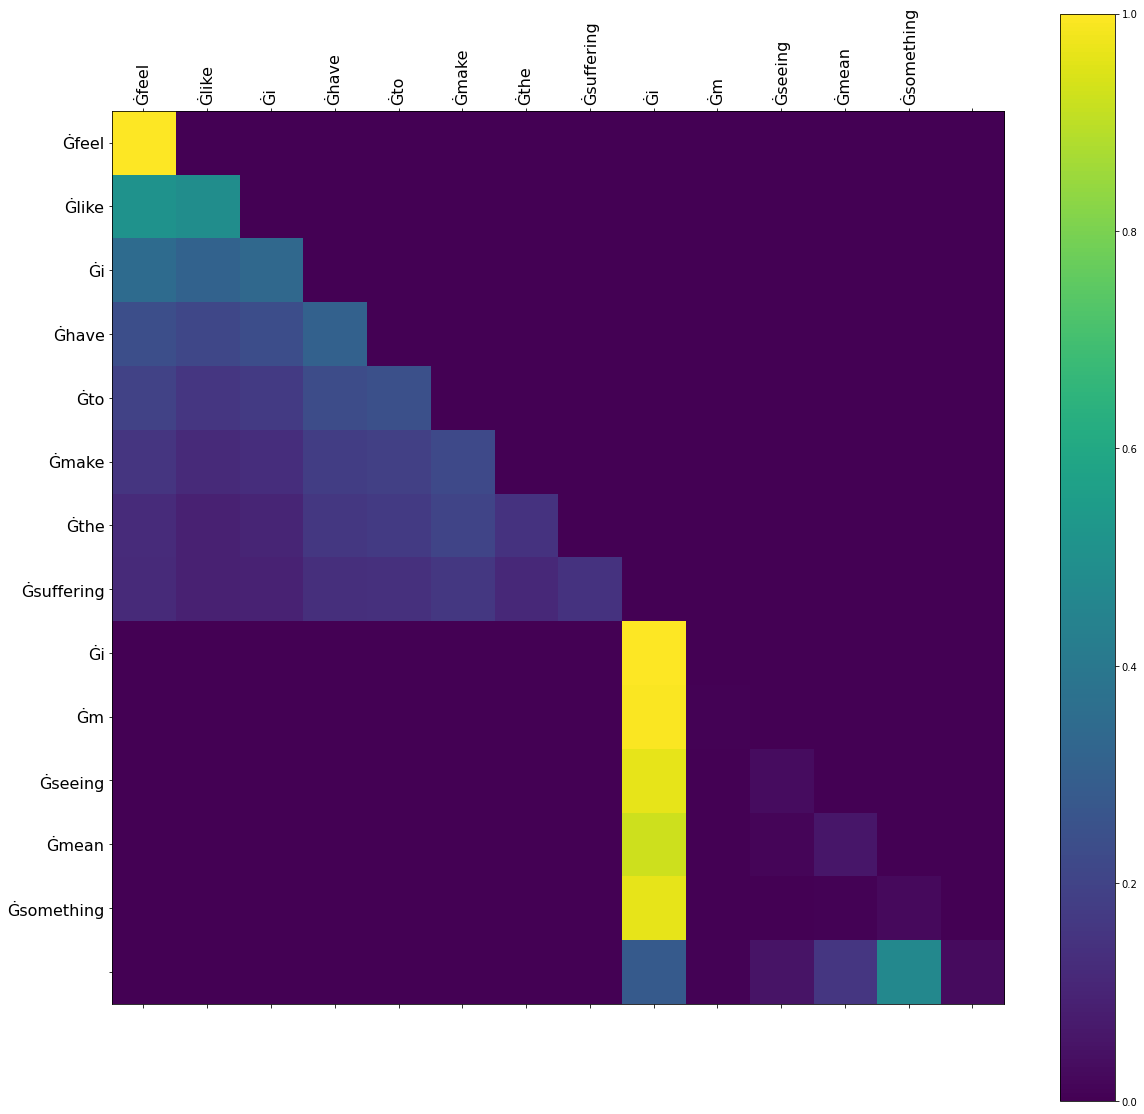

In [ ]:
text = emotion_dataset["train"]["text"][10] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

In [ ]:
with torch.no_grad():
    i = 0
    test_acc = 0
    for batch in test_loader:
            i+=1
            optimizer.zero_grad()
            size = batch['input_ids'].shape[0]
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(size, 128).to(device)
            mask = batch['mask'].view(size, 128).to(device)
            outputs = model_0(tokens, attention_mask = mask)
            output_tensor = outputs[0].to(device)
            output_tensor = torch.argmax(output_tensor, dim = 1)
            test_acc += accuracy_score(target.cpu(), output_tensor.cpu())
print(f"Test Acc для непредтренированной модели: {test_acc/i}")
with torch.no_grad():
    i = 0
    test_acc = 0
    for batch in test_loader:
            i+=1
            optimizer.zero_grad()
            size = batch['input_ids'].shape[0]
            target = batch['target'].to(device)
            tokens = batch['input_ids'].view(size, 128).to(device)
            mask = batch['mask'].view(size, 128).to(device)
            outputs = model_1(tokens, attention_mask = mask)
            output_tensor = outputs[0].to(device)
            output_tensor = torch.argmax(output_tensor, dim = 1)
            test_acc += accuracy_score(target.cpu(), output_tensor.cpu())
print(f"Test Acc для предтренированной модели: {test_acc/i}")

Test Acc для непредтренированной модели: 0.8515625
Test Acc для предтренированной модели: 0.9091796875


## Отчет


1) Как и следовало ожидать предобученная на задаче language modeling сеть выдала значительно лучшие результаты

2) Больше всего внимания модель обращает на первые слова, на слова по диагонали то есть можно сказать на "последнее" слово. Так же я заметил что часто модель обращает внимания на местоимения и служебные слова разделяющие части предложения.

3) Первые головы показывают какой-то более-менее осмысленный результат. Чем дальше тем чаще попадается что все внимание уделено одному слову.